<a href="https://colab.research.google.com/github/searcherm1/first_project/blob/master/%D0%9F%D1%80%D0%BE%D0%B3%D0%BD%D0%BE%D0%B7%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%B7%D0%B0%D0%BA%D0%B0%D0%B7%D0%BE%D0%B2_%D1%82%D0%B0%D0%BA%D1%81%D0%B8_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Проект прогнозирования заказов такси

## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.
Для решения этой задачи необходимо построить модель для такого предсказания.
Значение метрики RMSE на тестовой выборке должно быть не больше 48.

## Цель

Целью проекта является построенние модели, которая решает задачу регрессии количества заказов на следующий час. При этом в качестве метрики используется RMSE и для тестовой выборки она не должна превышать 48 заказов.

## Инструкция по выполнению проекта

В проекте будет выполнено следующее:
* загрузка данных и их ресемплирование по одному часу;
* анализ данных;
* обучение разных моделей с различными гиперпараметрами. При этом  тестовая выборка будет размером 10% от исходных данных;
* проверка данных на тестовой выборке и выводы.

## Импорт бибилиотек

In [ ]:
!pip install phik -q
!pip install shap -q
!pip install catboost -q

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC
from catboost import CatBoostRegressor

from sklearn.metrics import (
                             mean_absolute_error,
                             mean_squared_error
                            )
#from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import random
from statsmodels.tsa.seasonal import seasonal_decompose

plt.rcParams['font.size'] = 18.0
plt.rcParams.update({'axes.titlesize': 'large'})
sns.set_context(
                'notebook',
                rc={
                    'font.size': 15,
                    'axes.titlesize': 10,
                    'xtick.labelsize': 'small',
                    'ytick.labelsize': 'small',
                    'legend.fontsize': 'small',
                    'legend.title_fontsize': 10
                }
            )
sns.set (rc = {'figure.figsize':(10, 10)})
RANDOM_STATE = 2025

## Загрузка данных

In [ ]:
try:
	df = pd.read_csv('/datasets/taxi.csv',
                    index_col=[0],
                    parse_dates=[0]
                    )
except:
	df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv',
                    index_col=[0],
                    parse_dates=[0]
                    )
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Данные успешно зачитаны, индексом стало время заказа.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Проверка монотонности индекса.

In [ ]:
df.index.is_monotonic_increasing

True

Индекс, которым служит дата и время монотонно возрастает. Проверяю данные на пропуски:

In [ ]:
df.isna().sum()

,0
num_orders,0


## Исследовательский анализ данных

Вывожу максимальное и минимальное значения индекса:

In [ ]:
print(f'Минимальное значение индекса: {df.index.min()},\nМаксимальное значение индекса: {df.index.max()}')

Минимальное значение индекса: 2018-03-01 00:00:00,
Максимальное значение индекса: 2018-08-31 23:50:00


Итак, все данные за 2018 год. Строю график распределения целевого признака

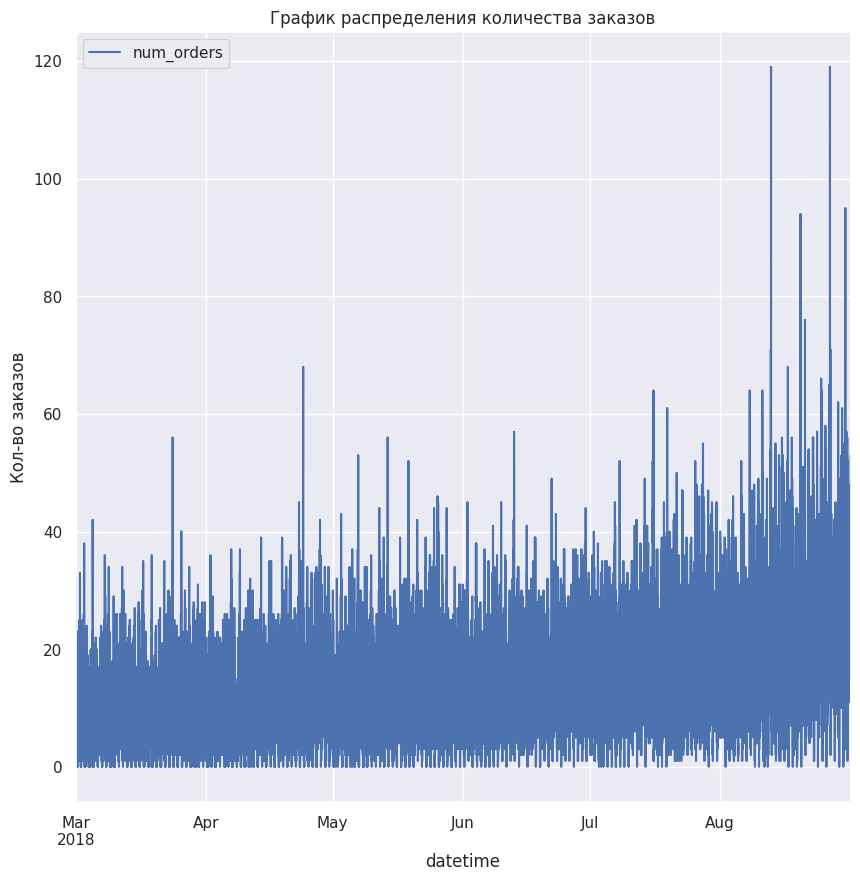

In [ ]:
df.plot(
    title = 'График распределения количества заказов',
    ylabel = 'Кол-во заказов'
)
plt.show;

Визуально есть сезонность. Лето - пора отпусков, поэтому и заказов такси с аэропорта больше. Их логично ожидать больше в дни перед праздниками и в последние дни праздников.

Произведу ресэмплинг данных по одному часу, согласно заданию.

In [ ]:
df = df.resample('1H').sum()
df.head()

/tmp/ipython-input-4010650514.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample('1H').sum()


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Провожу анализ трендов

In [ ]:
decomposed = seasonal_decompose(df)

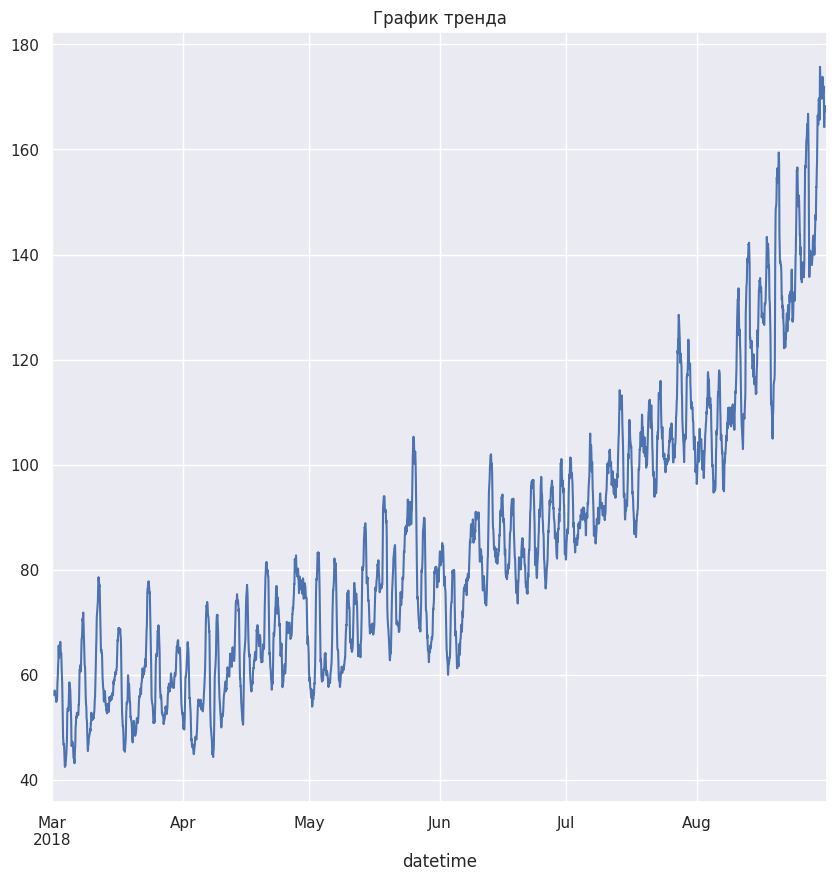

In [ ]:
decomposed.trend.plot(
    title = 'График тренда'
)
plt.show;

Строю график сезонности для имеющихся данных

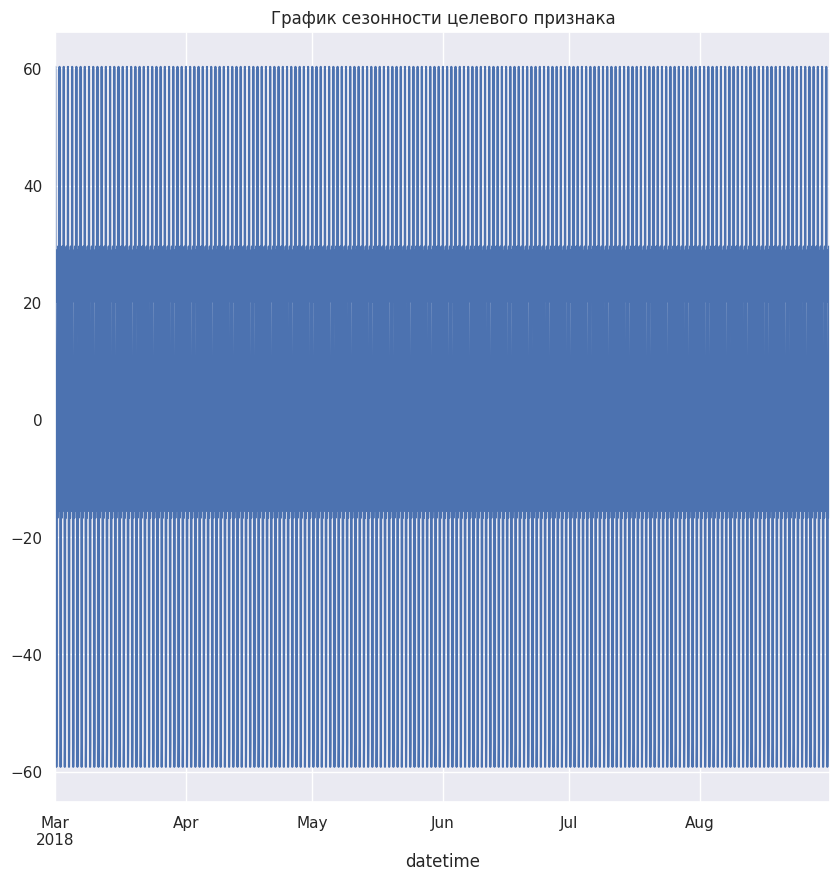

In [ ]:
decomposed.seasonal.plot(
                         title='График сезонности целевого признака'
                         ) # сезонная составляющая;
plt.show;

Как видно, сезонности не наблюдается ввиду того, что данные предоставлены за один год и то не весь.

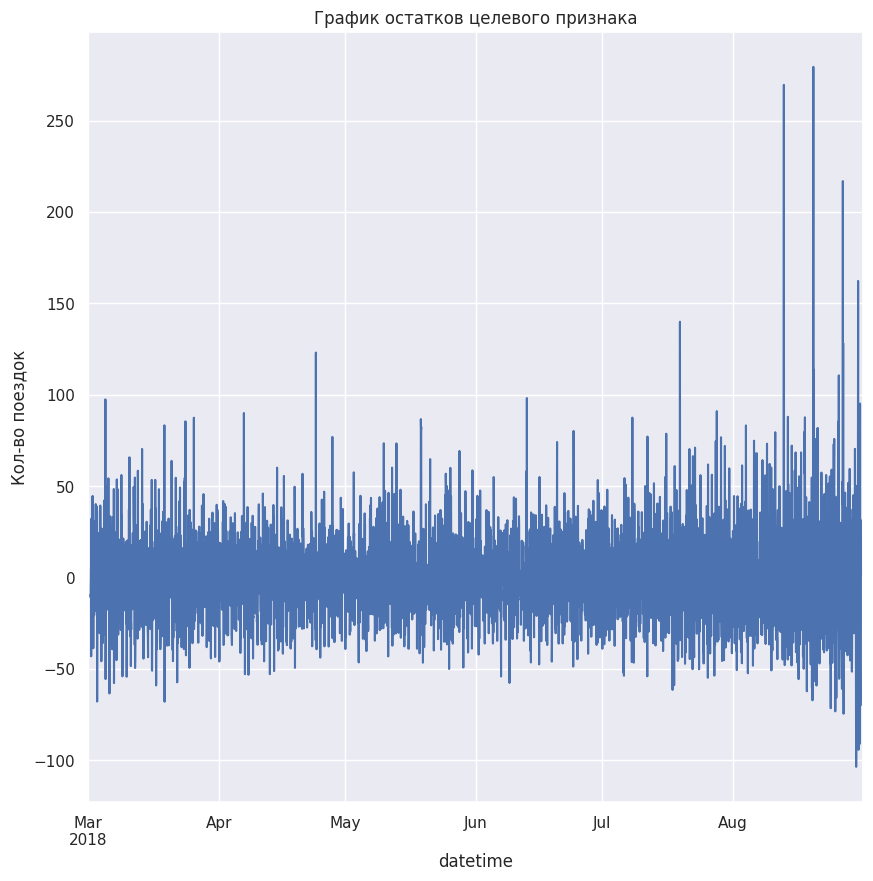

In [ ]:
decomposed.resid.plot(
                      title='График остатков целевого признака',
                      ylabel='Кол-во поездок')
plt.show;

По результатам вывода графиков видно, что определяющим является тренд.

### Создание новых признаков

In [ ]:
def make_features(data, max_lag=1, rolling_mean_size=5):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

    return data

In [ ]:
df_upd = make_features(df, 6, 5)
df_upd.head()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean
datetime,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN


In [ ]:
df_upd.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4416 non-null   int64  
 1   month         4416 non-null   int32  
 2   day           4416 non-null   int32  
 3   dayofweek     4416 non-null   int32  
 4   hour          4416 non-null   int32  
 5   lag_1         4415 non-null   float64
 6   lag_2         4414 non-null   float64
 7   lag_3         4413 non-null   float64
 8   lag_4         4412 non-null   float64
 9   lag_5         4411 non-null   float64
 10  lag_6         4410 non-null   float64
 11  rolling_mean  4411 non-null   float64
dtypes: float64(7), int32(4), int64(1)
memory usage: 379.5 KB


Выведу график суммарного числа заказов за месяц.

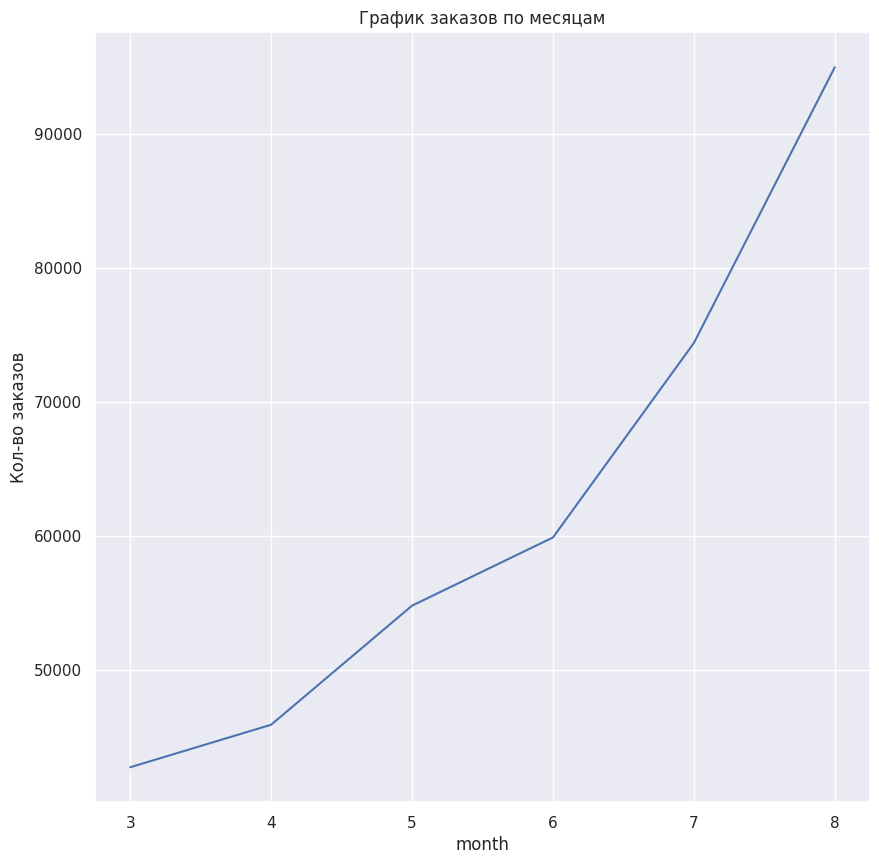

In [ ]:
df_upd.groupby('month').sum()['num_orders'].plot(
          title='График заказов по месяцам',
          ylabel='Кол-во заказов'
          )
plt.show();

Число заказов растет.

Выведу график распределения среднего числа заказов по дням недели

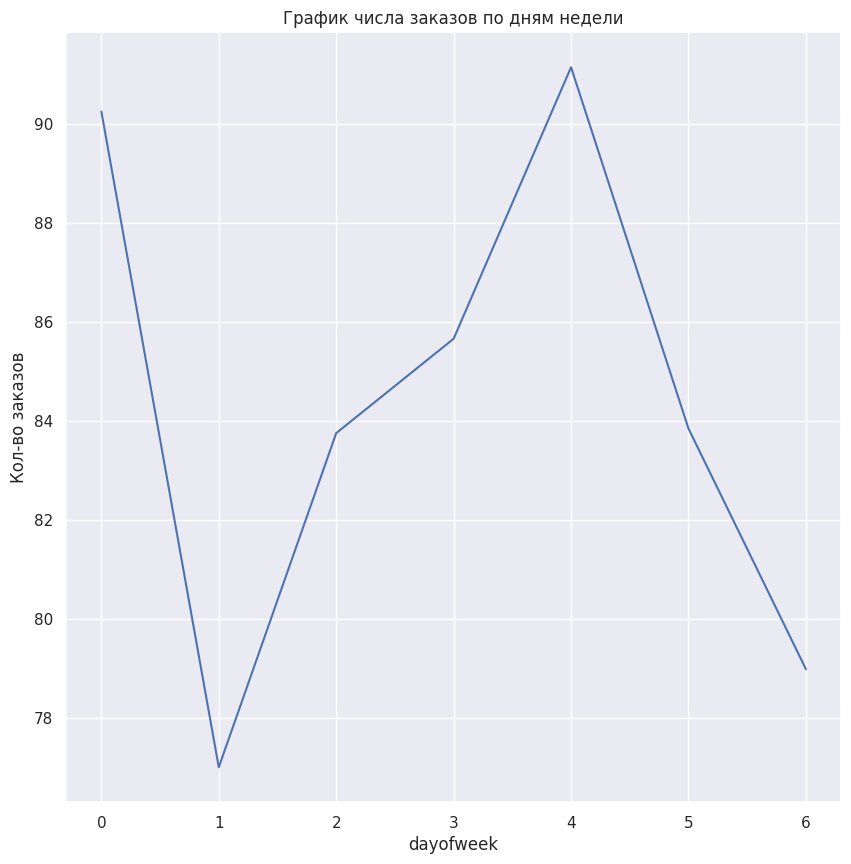

In [ ]:
df_upd.groupby('dayofweek')['num_orders'].\
mean().plot(
            title='График числа заказов по дням недели',
            ylabel='Кол-во заказов'
            )
plt.show();

Самые большие по заказам дни это понедельник и пятница. Вторник показывает минимальное число заказов.

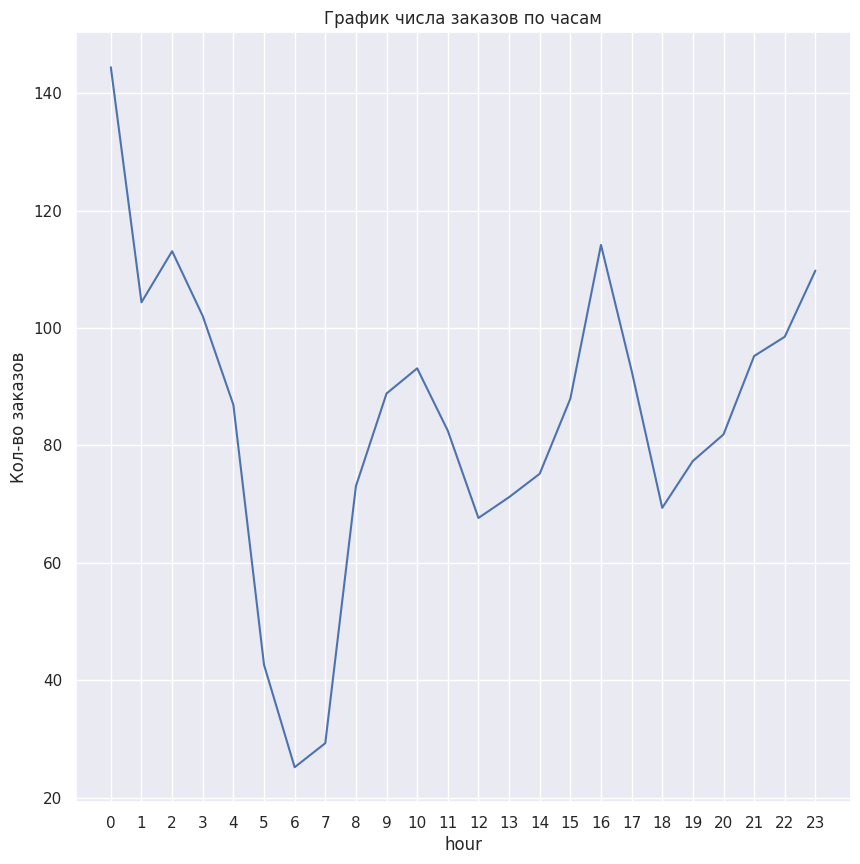

In [ ]:
df_upd.groupby('hour')['num_orders'].\
mean().plot(
            title='График числа заказов по часам',
            ylabel='Кол-во заказов'
            )
plt.xticks(range(0,24))
plt.show();

Наибольшее число заказов в 0 часов, второй пик в 10 часов, третий пик в 16 часов, с 18 до 23 часов число заказов растет.
<br>Самым тихим временем является 6 часов утра.

# Создание модели МО

Разделяю данные на обучающую и тестовую выборки.

In [ ]:
train, test = train_test_split(df_upd, shuffle=False, test_size=0.1)
train = train.dropna()
X_train = train.drop(['num_orders'], axis=1)
X_test = test.drop(['num_orders'], axis=1)
y_train = train['num_orders']
y_test = test['num_orders']

## Линейная регрессия

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
best_score_LR = mean_squared_error(y_test, y_pred_test) ** 0.5
print("RMSE обучающей выборки:", mean_squared_error(y_train, y_pred_train) ** 0.5)
print("RMSE тестовой выборки:", best_score_LR)

RMSE обучающей выборки: 30.470521097299454
RMSE тестовой выборки: 53.05143435320525


На обучающей выборке метрика RMSE хорошая, а вот на тестовой нет.

## Модель дерева решений

In [ ]:
param_grid_DT = {
                    'max_depth' : range(2, 71), # max_depth
                    'min_samples_leaf': range(1, 30), # min_samples_leaf
                    'min_samples_split': range(2, 40) # min_samples_split
}

In [ ]:
# Случайный поиск по сетке (без кросс-валидации)
n_iter = 400  # количество случайных комбинаций
best_score = 48
best_params = None

Алгоритм поиска наилучшей модели

In [ ]:
best_score_DT = best_score
for i in range(n_iter):
    # Случайная выборка параметров
    params = {
        'max_depth': random.choice(param_grid_DT['max_depth']),
        'min_samples_leaf': random.choice(param_grid_DT['min_samples_leaf']),
        'min_samples_split': random.choice(param_grid_DT['min_samples_split'])
    }
    # Обучение модели
    model = DecisionTreeRegressor(**params, random_state=RANDOM_STATE)
    #X_tr, X_val, y_tr, y_val = train_test_split(X_train,
    #                            y_train,
    #                            shuffle=False,
    #                            test_size=0.1)
    #
    model.fit(X_train, y_train)
    #model.fit(X_tr, y_tr)
    # Предсказание на валидационной выборке
    #
    #y_pred = model.predict(X_val)
    y_pred = model.predict(X_test)
    score = mean_squared_error(y_test, y_pred) ** 0.5
    #score = mean_squared_error(y_val, y_pred) ** 0.5
    # Сохранение лучших параметров
    if score <= best_score_DT:
        best_score_DT = score
        best_params = params
        print(f"[Итерация {i+1}] Новые лучшие параметры: {params} | Точность: {score:.4f}")
        model_DT = model
print("\nПоиск завершён.")
print("Лучшие параметры:", best_params,'\n Модель:', model_DT)
print("Лучшая точность на валидационной выборке:", best_score_DT)

[Итерация 50] Новые лучшие параметры: {'max_depth': 32, 'min_samples_leaf': 9, 'min_samples_split': 25} | Точность: 47.9749
[Итерация 94] Новые лучшие параметры: {'max_depth': 40, 'min_samples_leaf': 10, 'min_samples_split': 25} | Точность: 47.7392
[Итерация 239] Новые лучшие параметры: {'max_depth': 68, 'min_samples_leaf': 10, 'min_samples_split': 25} | Точность: 47.7392
[Итерация 269] Новые лучшие параметры: {'max_depth': 54, 'min_samples_leaf': 10, 'min_samples_split': 6} | Точность: 47.7191
[Итерация 285] Новые лучшие параметры: {'max_depth': 19, 'min_samples_leaf': 10, 'min_samples_split': 18} | Точность: 47.7191
[Итерация 311] Новые лучшие параметры: {'max_depth': 22, 'min_samples_leaf': 10, 'min_samples_split': 2} | Точность: 47.7191

Поиск завершён.
Лучшие параметры: {'max_depth': 22, 'min_samples_leaf': 10, 'min_samples_split': 2} 
 Модель: DecisionTreeRegressor(max_depth=22, min_samples_leaf=10, random_state=2025)
Лучшая точность на валидационной выборке: 47.71907266964755


Таким образом модель дерева решений с подобранными гиперпараметрами позволяет получить требуемую точность.

## Catboost модель

In [ ]:
param_grid_CB = {
                    'depth' : range(2, 17),
                    'num_trees': range(5, 21),
                    'min_data_in_leaf': range(1, 21),
                    #'l2_leaf_reg': [0.01, 0.1, 0.5]

}

In [ ]:
best_score_CB = best_score
for i in range(n_iter):
    # Случайная выборка параметров
    params = {
        'depth': random.choice(param_grid_CB['depth']),
        'num_trees': random.choice(param_grid_CB['num_trees']),
        'min_data_in_leaf': random.choice(param_grid_CB['min_data_in_leaf']),
        #'l2_leaf_reg': random.choice(param_grid_CB['l2_leaf_reg'])
    }
    # Обучение модели
    model = CatBoostRegressor(**params,
                              logging_level='Silent',
                              random_state=RANDOM_STATE)
    #X_tr, X_val, y_tr, y_val = train_test_split(X_train,
    #                            y_train,
    #                            shuffle=False,
    #                            test_size=0.1)
    #
    #model.fit(X_tr, y_tr)
    model.fit(X_train, y_train)
    # Предсказание на валидационной выборке
    #
    #y_pred = model.predict(X_val)
    y_pred = model.predict(X_test)
    score = mean_squared_error(y_test, y_pred) ** 0.5
    #score = mean_squared_error(y_val, y_pred) ** 0.5
    # Сохранение лучших параметров
    if score <= best_score_CB:
        best_score_CB = score
        best_params = params
        print(f"[Итерация {i+1}] Новые лучшие параметры: {params} | Точность: {score:.4f}")
        model_CB = model
print("\nПоиск завершён.")
print("Лучшие параметры:", best_params,'\n Модель:', model_CB)
print("Лучшая точность на валидационной выборке:", best_score_CB)

[Итерация 9] Новые лучшие параметры: {'depth': 4, 'num_trees': 19, 'min_data_in_leaf': 19} | Точность: 47.5399
[Итерация 39] Новые лучшие параметры: {'depth': 5, 'num_trees': 18, 'min_data_in_leaf': 7} | Точность: 44.3332
[Итерация 128] Новые лучшие параметры: {'depth': 5, 'num_trees': 18, 'min_data_in_leaf': 18} | Точность: 44.3332
[Итерация 158] Новые лучшие параметры: {'depth': 5, 'num_trees': 19, 'min_data_in_leaf': 3} | Точность: 44.1728
[Итерация 325] Новые лучшие параметры: {'depth': 5, 'num_trees': 20, 'min_data_in_leaf': 17} | Точность: 43.4658

Поиск завершён.
Лучшие параметры: {'depth': 5, 'num_trees': 20, 'min_data_in_leaf': 17} 
 Модель: <catboost.core.CatBoostRegressor object at 0x7dd4d92327e0>
Лучшая точность на валидационной выборке: 43.46578486529845


Как видно, самую лучшую метрику удалось получить на модели Catboost с гиперпараметрами depth=5, num_trees=20, min_dsta_in_leaf=17.

# Выводы

В работе была решена задача создания модели прогнозирования количества заказов такси по предоставленным данным.
<br>Был проведен исследовательский анализ данных, убраны пропуски, добавлены новые признаки.
<br>Были рассмотрены три модели регресси - линейная, древесная и CatBoost. У последних двух путем подбора гиперпараметром удалось получить модель с метрикой RMSE на тестовой выборке меньше 48 заказов.
<br> Самой лучшей оказалась модель Catboost Regressor, однако время подбора параметров для неё было значительно большим, чем для DecisionTree.